In [10]:
# Imports
import qiskit
import pennylane as qml
import tensorflow as tf
import numpy as np
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt

tf.keras.backend.set_floatx('float64')

In [2]:
qiskit.IBMQ.save_account('your-token')

configrc.store_credentials:WARNING:2021-11-06 12:30:10,964: Credentials already present. Set overwrite=True to overwrite.


In [3]:
qiskit.IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [38]:
provider = qiskit.IBMQ.get_provider('ibm-q') # select the provider
backend = provider.get_backend('ibmq_bogota') # select the name of the quatum computer to use
print("real device:", backend.name())
dev = qml.device('qiskit.ibmq', wires=2, backend=backend.name(), provider=provider)
#dev = qml.device("default.qubit", wires=2)

real device: ibmq_bogota


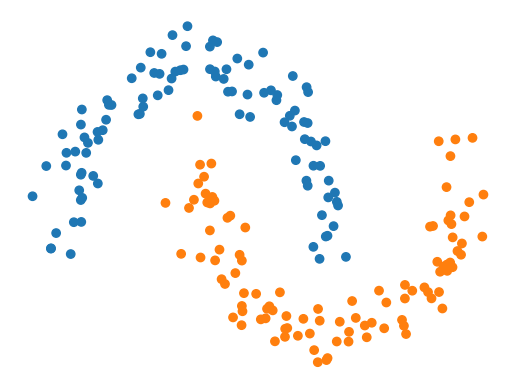

In [17]:
np.random.seed(42)
tf.random.set_seed(42)

x, y = make_moons(n_samples=200, noise=0.1)
y_hot = tf.keras.utils.to_categorical(y, num_classes=2)  # one-hot encoded labels

c = ["#1f77b4" if y_ == 0 else "#ff7f0e" for y_ in y]  # colours for each class
plt.axis("off")
plt.scatter(x[:, 0], x[:, 1], c=c)
plt.show()

In [39]:
# Define quantum layer
n_qubits = 2

@qml.qnode(dev)
def qnode(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.templates.BasicEntanglerLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

In [43]:
# Convert quantum layer to keras
n_layers = 4
weight_shapes = {"weights": (n_layers, n_qubits)}
qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=n_qubits)

In [44]:
# Define classical layers
clayer_1 = tf.keras.layers.Dense(2)
clayer_2 = tf.keras.layers.Dense(2, activation="sigmoid")

In [46]:
model = tf.keras.models.Sequential([clayer_1, qlayer, clayer_2])
opt = tf.keras.optimizers.Adam(learning_rate=0.1)
model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])
fitting = model.fit(x, y_hot, epochs=10, batch_size=5, validation_split=0.25, verbose=2)

Epoch 1/10
30/30 - 4s - loss: 0.3519 - accuracy: 0.8667 - val_loss: 0.3686 - val_accuracy: 0.8400
Epoch 2/10
30/30 - 4s - loss: 0.3298 - accuracy: 0.8667 - val_loss: 0.3361 - val_accuracy: 0.8400
Epoch 3/10
30/30 - 4s - loss: 0.3158 - accuracy: 0.8800 - val_loss: 0.3923 - val_accuracy: 0.8400
Epoch 4/10
30/30 - 4s - loss: 0.3678 - accuracy: 0.8333 - val_loss: 0.3519 - val_accuracy: 0.8200
Epoch 5/10
30/30 - 4s - loss: 0.3575 - accuracy: 0.8400 - val_loss: 0.3886 - val_accuracy: 0.8600
Epoch 6/10
30/30 - 4s - loss: 0.3299 - accuracy: 0.8533 - val_loss: 0.3950 - val_accuracy: 0.8200
Epoch 7/10
30/30 - 4s - loss: 0.3343 - accuracy: 0.8733 - val_loss: 0.2933 - val_accuracy: 0.8400
Epoch 8/10
30/30 - 4s - loss: 0.2321 - accuracy: 0.9133 - val_loss: 0.1986 - val_accuracy: 0.9400
Epoch 9/10
30/30 - 4s - loss: 0.1866 - accuracy: 0.9600 - val_loss: 0.1145 - val_accuracy: 0.9800
Epoch 10/10
30/30 - 4s - loss: 0.1224 - accuracy: 0.9600 - val_loss: 0.2188 - val_accuracy: 0.9200


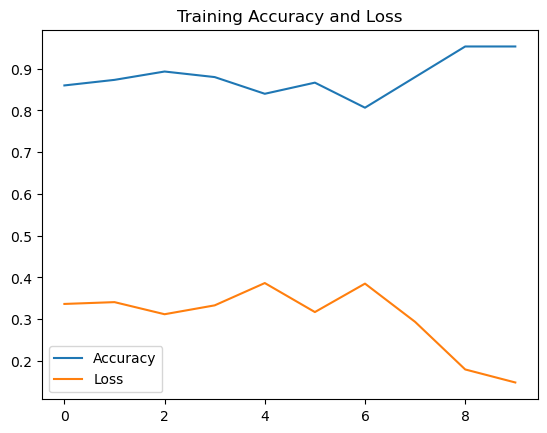

In [36]:
plt.plot(fitting.history['accuracy'], label='Accuracy')
plt.plot(fitting.history['loss'], label='Loss')
plt.legend(loc='best')
plt.title('Training Accuracy and Loss')
plt.show()

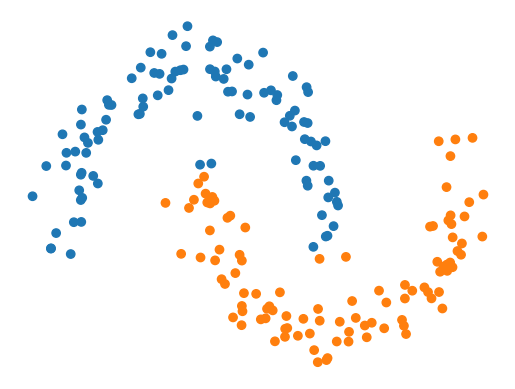

In [37]:
y_prob = model.predict(x)
y_class = y_prob.argmax(axis=-1)

c = ["#1f77b4" if y_ == 0 else "#ff7f0e" for y_ in y_class]  # colours for each class
plt.axis("off")
plt.scatter(x[:, 0], x[:, 1], c=c)
plt.show()

In [5]:
qr = qiskit.QuantumRegister(1)
cr = qiskit.ClassicalRegister(1)
program = qiskit.QuantumCircuit(qr, cr)

In [6]:
program.measure(qr,cr) # The qubit is measured and stored in the classic bit.

In [7]:
program.draw()

┌─┐
q0_0: ┤M├
      └╥┘
c0: 1/═╩═
       0

In [8]:
#job = qiskit.execute( program, qiskit.BasicAer.get_backend('qasm_simulator') )
job = qiskit.execute( program, backend )
print( job.result().get_counts() )

{'0': 1016, '1': 8}
